In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from wordcloud import WordCloud, STOPWORDS

In [2]:
def data_form():
    filename = 'https://infographics.channelnewsasia.com/covid-19/newrec.csv'
    df = pd.read_csv(filename)
    df = df.drop(['Province/State', 'Latitude', 'Longitude'], axis=1)
    date = df['Last Update'][0].split('T')[0]
    date = [int(i) for i in '2020-03-11'.split('-')]
    date = datetime.datetime(*date)
    date = date.strftime('%d %b,%Y ')
    df = df.drop(['Last Update'], axis=1)
    df = df.groupby(['Country/Region']).first()
    for i in df.columns:
        df[i] = pd.to_numeric(df[i])
    df = df.sort_values(by=['Confirmed'], ascending=False)
    return df, date


def top_value(df, date, val=None):
    full_data = {}
    if val == None:
        val = df.shape[0]
    temp_data = df[:val]
    temp_data = temp_data.loc[~(temp_data == 0).any(axis=1)]
    full_data['country'] = temp_data.index.values
    full_data['death'] = temp_data.Deaths.values
    full_data['recover'] = temp_data.Recovered.values
    full_data['affected'] = (temp_data.Confirmed.values - (
        full_data['death']+full_data['recover']))/temp_data.Confirmed.values
    full_data['recover'] = temp_data.Recovered.values / \
        temp_data.Confirmed.values
    full_data['death'] = temp_data.Deaths.values/temp_data.Confirmed.values
    full_data['actual'] = temp_data.Confirmed.values
    full_data['date'] = date
    return full_data


def data_plot(main_data, save=False):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    plt.bar(main_data['country'], main_data['recover'],
            color='limegreen', edgecolor='white', label='Recover')
    plt.bar(main_data['country'], main_data['affected'], bottom=main_data['recover'],
            color='darkorange', edgecolor='white', label='Affected')
    plt.bar(main_data['country'], main_data['death'], bottom=main_data['affected'] +
            main_data['recover'], color='crimson', edgecolor='white', label='Death')

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('Corona Affected on '+main_data['date'], fontsize=25)

    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    xtickNames = ax.set_xticklabels(main_data['country'])

    ax.legend(fontsize=15)
    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Corona.png')
    plt.show()


def show_wordcloud(main_data, save=False):
    stopwords = set(STOPWORDS)

    data = data = {i: j for i, j in zip(
        main_data['country'], main_data['actual'])}
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=len(data),
        max_font_size=80,
        scale=3,
        random_state=200
    ).generate_from_frequencies(data).recolor(random_state=63008)

    plt.figure(figsize=(16, 8), facecolor='white', edgecolor='blue')
    plt.title('Corona Affected on '+main_data['date'], fontsize=25)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    if save:
        plt.savefig('Corona Affected people.png')
    plt.show()

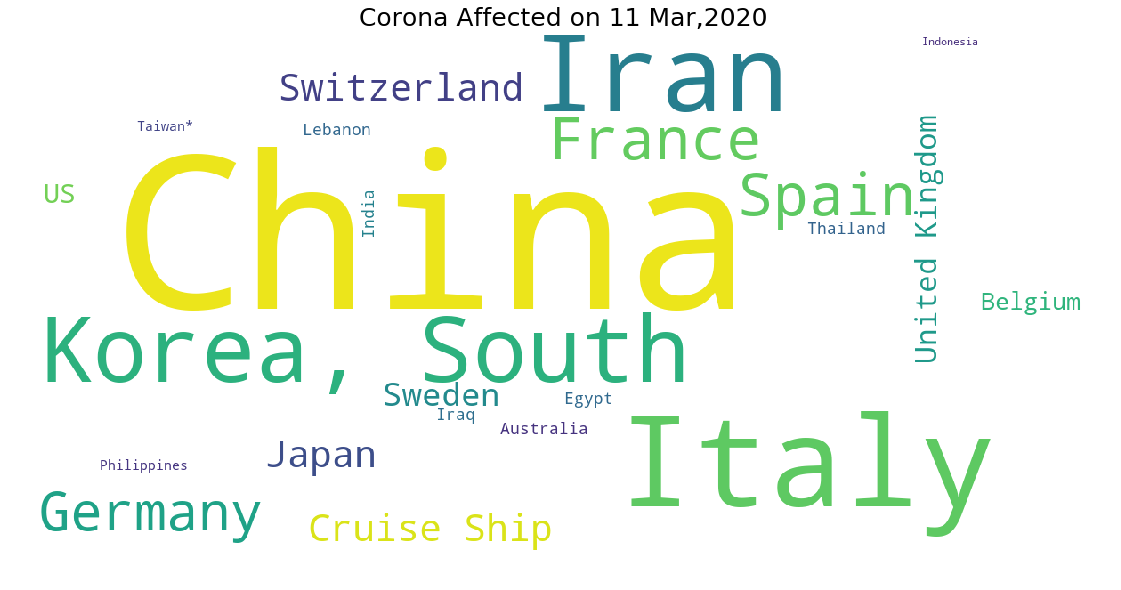

In [3]:
df, date = data_form()
main_data = top_value(df, date)
show_wordcloud(main_data, True)

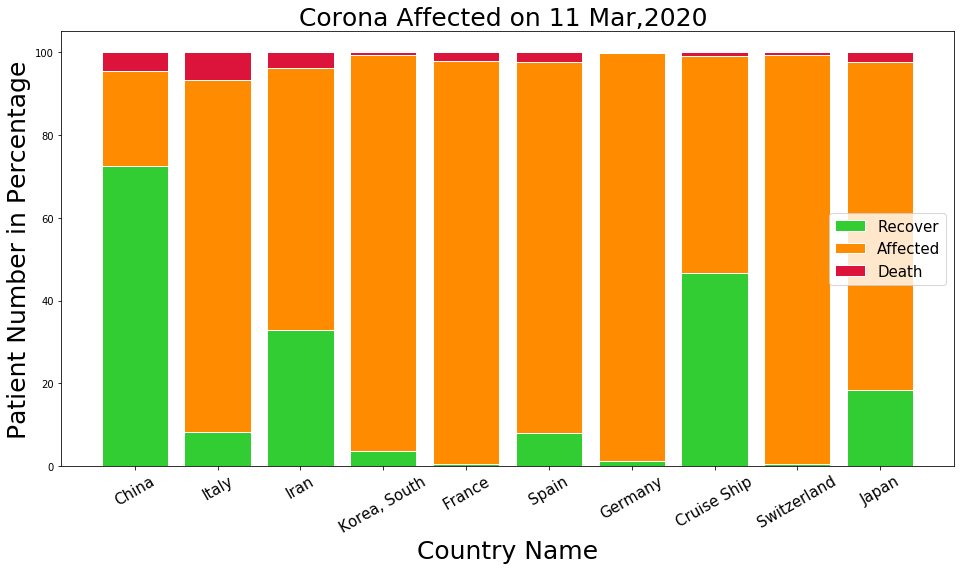

In [4]:
df, date = data_form()
main_data = top_value(df, date, 10)
data_plot(main_data, True)